# Calculate Effective Area

In this example we will calculate the effective area of a detector over a range of energies.

### WARNING:
In order to finish reasonably quickly, the number of events thrown in this example is low. This means that there are likely not enough events to accurately represent the effective area of the detector. For an accurate measurement, the number of events must be increased, but this will need much more time to run in that case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyrex
import pyrex.custom.ara as ara

First let's set the number of events that we will be throwing at each energy, and the energies we will be using. As stated in the warning, the number of events is set low to speed up the example, but that means the results are likely inaccurate. The energies are high to increase the chance of triggering.

In [2]:
n_events = 100
energies = [1e9, 2e9, 5e9, 1e10] # GeV

Next, set up the detector to be measured. Here we use a single standard ARA station.

In [3]:
detector = ara.HexagonalGrid(station_type=ara.RegularStation,
                             stations=1)
detector.build_antennas(power_threshold=-6.15)

Now set up a neutrino generator for each energy. We'll use unrealistically small volumes to increase the chance of triggering.

In [4]:
generators = [pyrex.CylindricalGenerator(dr=1000, dz=1000, energy=energy)
              for energy in energies]

And then set up the event kernels for each energy. Let's use the ArasimIce class as our ice model since it calculates attenuations faster at the loss of some accuracy.

In [5]:
kernels = [pyrex.EventKernel(generator=gen, antennas=detector,
                             ice_model=pyrex.ice_model.ArasimIce())
           for gen in generators]

Now run each kernel and record the number of events from each that triggered the detector. In this case we'll set our trigger condition to 3/8 antennas triggering in a single polarization.

In [6]:
triggers = np.zeros(len(energies))
for i, kernel in enumerate(kernels):
    print("Running energy", energies[i])
    for j in range(n_events):
        print(j, "..", sep="", end="")
        detector.clear(reset_noise=True)
        particle = kernel.event()
        triggered = detector.triggered(station_requirement=1,
                                       polarized_antenna_requirement=3)
        if triggered:
            triggers[i] += 1
            print("y", end=" ")
        else:
            print("n", end=" ")
        
        if j%10==9:
            print(flush=True)
    print(triggers[i], "events triggered at", energies[i]/1e6, "PeV")
print("Done")

Running energy 1000000000.0
0..n 1..n 2..n 3..n 4..n 5..n 6..n 7..n 8..y 9..n 
10..n 11..n 12..y 13..n 14..n 15..n 16..n 17..n 18..n 19..n 
20..n 21..n 22..n 23..n 24..n 25..n 26..n 27..n 28..n 29..n 
30..n 31..n 32..n 33..n 34..n 35..n 36..n 37..n 38..n 39..n 
40..n 41..n 42..n 43..n 44..n 45..n 46..n 47..n 48..n 49..n 
50..n 51..n 52..n 53..n 54..n 55..y 56..n 57..n 58..n 59..n 
60..n 61..n 62..y 63..n 64..n 65..n 66..n 67..n 68..n 69..n 
70..n 71..y 72..n 73..n 74..n 75..n 76..n 77..n 78..n 79..n 
80..y 81..n 82..n 83..n 84..n 85..n 86..n 87..n 88..n 89..n 
90..n 91..n 92..n 93..n 94..n 95..n 96..n 97..n 98..n 99..n 
6.0 events triggered at 1000.0 PeV
Running energy 2000000000.0
0..n 1..y 2..n 3..n 4..n 5..n 6..y 7..n 8..n 9..n 
10..n 11..n 12..n 13..n 14..n 15..n 16..n 17..n 18..n 19..n 
20..n 21..y 22..n 23..y 24..n 25..n 26..n 27..n 28..n 29..n 
30..n 31..n 32..n 33..n 34..n 35..n 36..n 37..n 38..n 39..n 
40..y 41..n 42..n 43..n 44..y 45..n 46..n 47..n 48..n 49..n 
50..y 51..n 52

Now that we have the trigger counts for each energy, we can calculate the effective volumes by scaling the trigger probability by the generation volume. Errors are calculated assuming poisson counting statistics.

In [7]:
generation_volumes = np.ones(4)*(np.pi*1000**2)*1000
effective_volumes = triggers / n_events * generation_volumes
volume_errors = np.sqrt(triggers) / n_events * generation_volumes

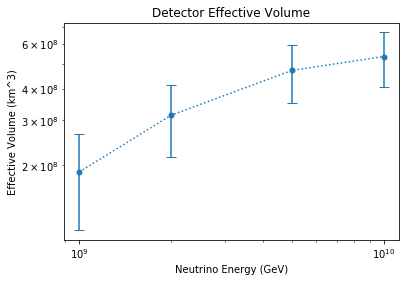

In [8]:
plt.errorbar(energies, effective_volumes, yerr=volume_errors,
             marker="o", markersize=5, linestyle=":", capsize=5)
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.title("Detector Effective Volume")
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel("Effective Volume (km^3)")
plt.show()

Then from the effecitve volumes, we can calculate the effective areas. The effective area is the probability interaction in the ice volume times the effective volume. The probability of interaction in the ice volume is given by the interaction cross section times the density of the ice. Calculate the cross section as an average of the neutrino and antineutrino cross sections.

In [9]:
cross_sections = np.zeros(len(energies))
for i, energy in enumerate(energies):
    nu = pyrex.Particle(particle_id="nu_e", vertex=(0, 0, 0),
                        direction=(0, 0, 1), energy=energy)
    nu_bar = pyrex.Particle(particle_id="nu_e_bar", vertex=(0, 0, 0),
                            direction=(0, 0, 1), energy=energy)
    cross_sections[i] = (nu.interaction.total_cross_section +
                         nu_bar.interaction.total_cross_section) / 2
ice_density = 0.92 # g/cm^3
ice_density *= 1e15 # converted to g/km^3 = nucleons/km^3
effective_areas = 6.022e23 * ice_density * cross_sections * effective_volumes
effective_areas *= 1e-4 # converted from cm^2 to m^2
area_errors = 6.022e23 * ice_density * cross_sections * volume_errors * 1e-4

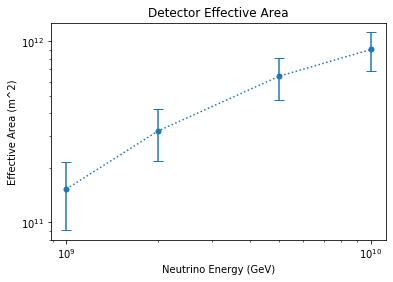

In [10]:
plt.errorbar(energies, effective_areas, yerr=area_errors,
             marker="o", markersize=5, linestyle=":", capsize=5)
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.title("Detector Effective Area")
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel("Effective Area (m^2)")
plt.show()